<a href="https://colab.research.google.com/github/Yongtae723/personal_study_code/blob/main/%E5%9C%B0%E4%B8%AD%E3%81%AB%E5%9F%8B%E3%81%BE%E3%82%8B%E5%A1%A9%E3%81%AE%E5%A0%B4%E6%89%80%E3%82%92%E4%BA%88%E6%B8%AC%E3%81%99%E3%82%8B%E3%83%A2%E3%83%87%E3%83%AB(U_NET).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

practice:地中に埋まる塩の場所を予測するモデル(U-NET) [TSG data from Kaggle competition ](https://www.kaggle.com/c/tgs-salt-identification-challenge/overview)



## kaggleからデータをgoogle colabのストレージに入れる

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yongte1993","key":"00e852b5b86fed0ac6c85e25f42dcdd1"}'}

In [ ]:
!mkdir -p ~/.kaggle  #kaggleのファイルを作る
!cp kaggle.json ~/.kaggle  #kaggleのトークンをコピーする

#kaggleのアクセス権を変更する
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# データのインポート
!kaggle competitions download -c tgs-salt-identification-challenge

  0% 0.00/322k [00:00<?, ?B/s]
100% 322k/322k [00:00<00:00, 43.5MB/s]
  0% 0.00/264k [00:00<?, ?B/s]
100% 264k/264k [00:00<00:00, 81.7MB/s]
  0% 0.00/922k [00:00<?, ?B/s]
100% 922k/922k [00:00<00:00, 61.1MB/s]
 86% 140M/163M [00:00<00:00, 116MB/s] 
100% 163M/163M [00:01<00:00, 169MB/s]
 90% 34.0M/37.9M [00:00<00:00, 28.2MB/s]
100% 37.9M/37.9M [00:00<00:00, 59.4MB/s]


In [ ]:
!ls

!unzip train.zip
# !unzip test.zip

### データの確認

In [ ]:
!pip install imageio #画像データを読み込むためのモジュール

In [ ]:
import os
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [ ]:
# indexを入力するとデータをディスクから読み込むClassの定義

class TGSSaltDataset():
  def __init__(self , root_path , file_list):
    self.root_path = root_path
    self.file_list = file_list
    
  def __len__(self):
    return len(file_list)
    
  def __getitem__(self , index):
    file_id = self.file_list[index]
    image_folder = os.path.join(self.root_path, 'images')
    image_path = os.path.join(image_folder,file_id  +'.png') #indexで指定したimage1枚のファイルパス
    
    mask_folder = os.path.join(self.root_path, 'masks')
    mask_path = os.path.join(mask_folder,file_id  +'.png')
    
    image = np.array(imageio.imread(image_path) , dtype = np.uint8)
    image = image[:,:,0]
    mask = np.array(imageio.imread(mask_path) , dtype = np.uint8)

    return image, mask
  
  


In [ ]:
train_mask = pd.read_csv('train.csv') # id , rle_mask(画像をrle形式で圧縮したデータ)
depth = pd.read_csv('depths.csv') # id , depth of salt

print(train_mask.head(5))

           id                                           rle_mask
0  575d24d81d                                                NaN
1  a266a2a9df                                          5051 5151
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...


In [ ]:
train_path = './'
file_list = list(train_mask['id'].values)

dataset = TGSSaltDataset(train_path ,file_list)

In [ ]:
# dataは２枚の画像からなるため、2枚の画像を並べて表示する関数
def plot2x2array(image , mask):
  f , ax = plt.subplots(1,2)
  f.patch.set_facecolor('white')
  ax[0].imshow(image,cmap = 'gray')
  ax[1].imshow(mask ,cmap = 'gray')
  ax[0].grid()
  ax[1].grid()
  ax[0].set_title('Image')
  ax[1].set_title('Mask')
  

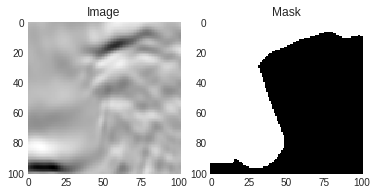

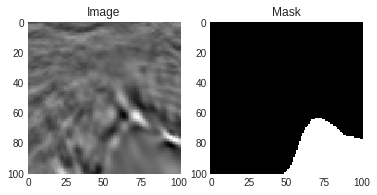

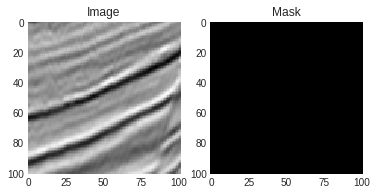

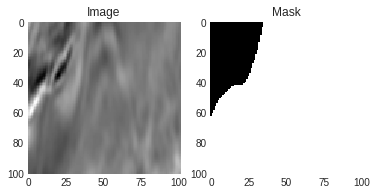

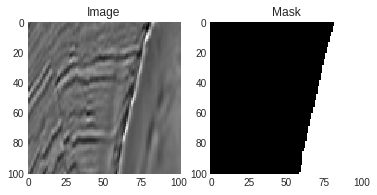

In [ ]:
# 画像の確認 , maskの白領域がsaltがある場所
for i in range(5):
  image,mask = dataset[np.random.randint(0, len(dataset))]
  plot2x2array(image,mask)
  

Text(0, 0.5, 'Count')

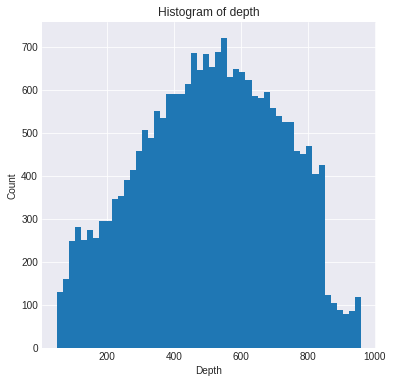

In [ ]:
#depthの確認
plt.figure(figsize = (6,6) , facecolor = 'white')
plt.hist(depth['z'] , bins =50)
plt.title('Histogram of depth')
plt.xlabel('Depth')
plt.ylabel('Count')

##ここからちょっと寄り道

###rle圧縮データを解凍するプログラム
###salt proportionを求める

rle圧縮について忘れたら[ここ](https://ja.wikipedia.org/wiki/%E9%80%A3%E9%95%B7%E5%9C%A7%E7%B8%AE)参照すること

In [ ]:
# rleから画像データに変換する関数
def rleTomask(rleString , height , width):
  rows , cols = height , width
  #rle_maskがNaN(saltがないデータ)だとエラーになるためtryで処理
  try:
    rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
    rlePairs = np.array(rleNumbers).reshape(-1,2)
    img = np.zeros(rows * cols , dtype = np.uint8)

    for index , length in rlePairs:
      index -=1
      img[index:index+length] = 255
      
    img = img.reshape(cols , rows)
    img = img.T
    

  except:
    img = np.zeros((cols , rows))
    
  return img


In [ ]:
# maskの画像の中でsaltが占める割合を計算する関数
def salt_proportion(imgArray):
  try:
    unique , counts = np.unique(imgArray , return_counts = True)
    ## The total number of pixels is 101*101 = 10,201
    return counts[1] / 10201
  
  except:
    return 0.0


In [ ]:
# rleTomaskの引数のためのサイズの取得
data_for_size = dataset[0]
rows_mask , cols_mask = data_for_size[1].shape
print(f'rows : {rows_mask} , cols : {cols_mask}')

rows : 101 , cols : 101


In [ ]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleTomask(x, rows_mask , cols_mask))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

           id                                           rle_mask  \
0  575d24d81d                                                NaN   
1  a266a2a9df                                          5051 5151   
2  75efad62c1  9 93 109 94 210 94 310 95 411 95 511 96 612 96...   
3  34e51dba6a  48 54 149 54 251 53 353 52 455 51 557 50 659 4...   
4  4875705fb0  1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...   
5  782ae9b7e7  1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...   
6  9842f69f8d                                                NaN   
7  aa94cfb806  1 28 102 28 203 29 304 30 405 32 506 33 607 34...   
8  50d3073821                                    1 2121 9293 909   
9  28f865caaa                                                NaN   

                                                mask  salt_proportion  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         0.000000  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...         0.504950  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Text(0.5, 1.0, 'mask image from rle transfar')

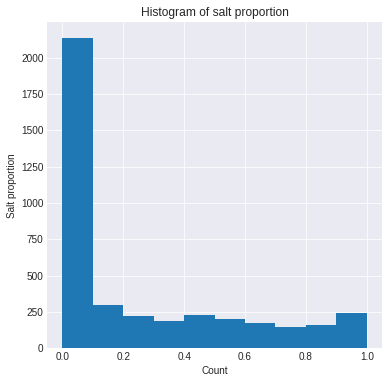

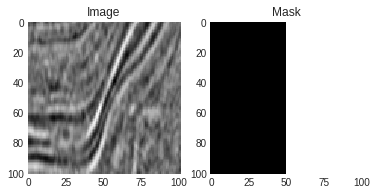

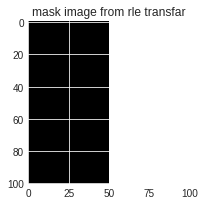

In [ ]:
# 上のセルの確認
print(train_mask.head(10))
plt.figure(figsize = (6,6) , facecolor = 'white')
train_mask['salt_proportion'].hist()
plt.title('Histogram of salt proportion')
plt.ylabel('Salt proportion')
plt.xlabel('Count')



image , mask = dataset[1]
plot2x2array(image,mask)
plt.figure(figsize = (3,3) , facecolor = 'white')
plt.imshow(train_mask['mask'].values[1],cmap = 'gray')
plt.title('mask image from rle transfar')

In [ ]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5, 0, 'salt proportion')

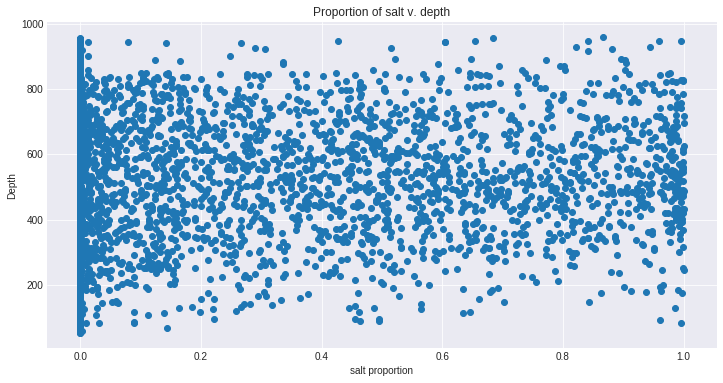

In [ ]:
# saltとdepthに何らかの相関があるのか目視で確認
plt.figure(figsize = (12, 6) , facecolor = 'white')
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')
plt.ylabel('Depth')
plt.xlabel('salt proportion')

## ここから本格的な機械学習

説明変数、目的変数の画像リストを作製

In [ ]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # original画像とoriginal画像を編集したcomsum画像を説明変数とする
n_features = 1 # inputとして画像データ以外も使う(今回はdepthの1変数)
#path_train = '../input/train/'
#path_test = '../input/test/'

In [ ]:
import sys
from tqdm import tqdm #forループの進行度合いを表す
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2] #images fileの中のデータの名前リストをすべて取得


# データの読み込み
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path

    # Depth
    X_feat[n] = depth[depth['id'] == id_.replace('.png', '')]['z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:98: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:27<00:00, 146.17it/s]

Done!


## Keras でモデル(U-NET)構築

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input , BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau , TensorBoard
from keras import backend as K
import tensorflow as tf

In [ ]:
#U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = BatchNormalization()(c1)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# ここでadditionalな特徴量を加える
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy' , metrics = ['accuracy']) 

#mean_iouでmetricsを定義したい場合

# def mean_iou(y_true, y_pred):# The mean_iouはpredictとmaskで重なる領域の割合い
#    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 1)
#    K.get_session().run(tf.local_variables_initializer())
#    return scor
# model.compile(optimizer='adam', loss='binary_crossentropy' , metrics=[mean_iou]) 
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_33 (BatchNo (None, 128, 128, 8)  32          conv2d_153[0][0]                 
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 128, 128, 8)  584         batch_normalization_33[0][0]     
__________________________________________________________________________________________________
batch_norm

## test dataとvalidation dataを分けて学習する

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [ ]:

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True, save_weights_only=True),
    TensorBoard(log_dir = './')
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=50, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))

Train on 3400 samples, validate on 600 samples
Epoch 1/50
3400/3400 [==============================] - 8s 2ms/step - loss: 0.4704 - acc: 0.7564 - val_loss: 0.7120 - val_acc: 0.2822

Epoch 00001: val_loss improved from inf to 0.71196, saving model to model-tgs-salt-1.h5
Epoch 2/50
3400/3400 [==============================] - 6s 2ms/step - loss: 0.3576 - acc: 0.8404 - val_loss: 4.3578 - val_acc: 0.2404

Epoch 00002: val_loss did not improve from 0.71196
Epoch 3/50
3400/3400 [==============================] - 6s 2ms/step - loss: 0.3143 - acc: 0.8688 - val_loss: 2.4559 - val_acc: 0.2714

Epoch 00003: val_loss did not improve from 0.71196
Epoch 4/50
3400/3400 [==============================] - 6s 2ms/step - loss: 0.2738 - acc: 0.8853 - val_loss: 2.3098 - val_acc: 0.2549

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.71196
Epoch 5/50
3400/3400 [==============================] - 6s 2ms/step - loss: 0.2325 - acc: 